# VALORACIÓN DE OPCIONES USANDO MONTECARLO

### Parámetros necesarios para valorar una opción:

| Descripción | Símbolo|
| -------------------------------------------------- | ---------|
| Valor actual del activo | **S0** |
| Valor de strike de la opción | **K** |
| Tasa de interés anual del activo libre de riesgo | **r** |
| Dividendos del activo | **div** |
| Tiempo hasta vencimiento | **T** |
| Varianza del activo | **sigma** |
| Número de intervalos hasta vencimiento | **steps** |


In [1]:
import numpy as np
import pandas as pd
import math as m
import scipy.stats as stats
import mibian
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

Leemos los datos del fichero csco_opt.xlsx

In [2]:
csco_opt_calls = pd.read_excel('./data/csco_opt.xlsx')
csco_opt_calls.head()

,lastTradeDate,strike,lastPrice,S0,T,vol
0,2022-08-19,40.0,10.05,48.700001,0.575342,32.958984
1,2022-08-19,42.5,8.35,48.700001,0.575342,33.447266
2,2022-08-19,45.0,6.25,48.700001,0.575342,29.296875
3,2022-08-19,47.5,4.65,48.700001,0.575342,27.709961
4,2022-08-19,50.0,3.45,48.700001,0.575342,27.282715


Grafico los precios y las volatilidades implícitas en función del valor de strike

array([<AxesSubplot: xlabel='strike'>, <AxesSubplot: xlabel='strike'>],
      dtype=object)

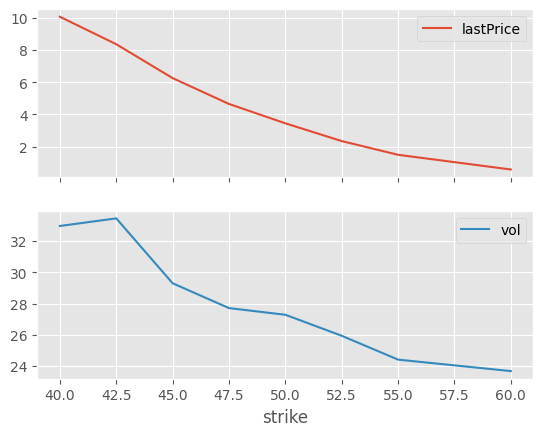

In [3]:
csco_opt_calls[['strike' , 'lastPrice', 'vol']].plot(x='strike', subplots=True)

Doy valores a los variables tomando la opción en la posición pos = 0 para asignar los valores de S0, K, r, div, T, sigma

In [4]:

pos = 0
S0 = csco_opt_calls.loc[pos, "S0"]
K = csco_opt_calls.loc[pos, "strike"]
T = csco_opt_calls.loc[pos, "T"]
r = 0.01
div = 0.0 #0.03
sigma = csco_opt_calls.loc[pos, "vol"]/100
steps = 50
num_sim = 1000
market_value = csco_opt_calls.loc[pos, "lastPrice"]

In [5]:
dt = T/steps
nudt = (r - 0.5*sigma**2)*dt
sigma_sdt = sigma*np.sqrt(dt)
lnS = np.log(S0)

In [6]:
Z = np.random.normal(size=(steps,num_sim))
delta_lnSt = nudt + sigma_sdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1,num_sim), fill_value=lnS), lnSt ))

In [7]:
ST = np.exp(lnSt)
CT = np.maximum(0, ST -K)
C0 = np.exp(-r*T)*CT[-1]
opt_price = C0.mean()

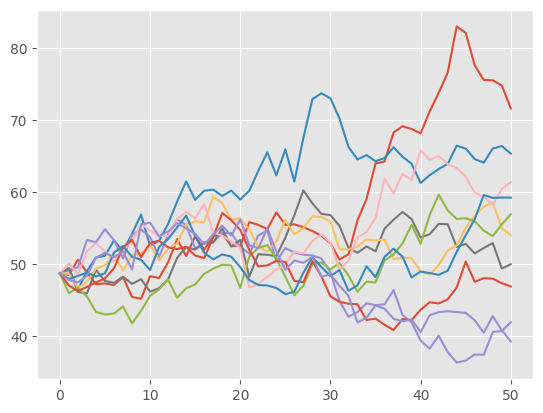

In [8]:
plt.plot(ST[:, 0:10]);

In [9]:
print(ST.mean())
print(CT.mean())
print(C0.mean())

48.830025479292445
9.387964877020453
10.583091670798048


In [10]:
sigma_C0 = np.sqrt( np.sum((C0 - C0.mean())**2)/ (num_sim-1))
SE = sigma_C0/np.sqrt(num_sim)
SE

0.34743951345574053

In [11]:
print(f" Valor de la opción call: {C0.mean():.2f} con SE: {SE:.2f}")

 Valor de la opción call: 10.58 con SE: 0.35


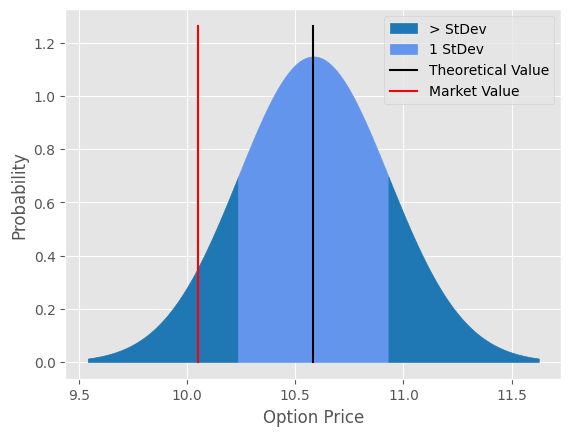

In [12]:

x1 = np.linspace(opt_price-3*SE, opt_price-1*SE)
x2 = np.linspace(opt_price-1*SE, opt_price+1*SE, 100)
x3 = np.linspace(opt_price+1*SE, opt_price+3*SE, 100)

s1 = stats.norm.pdf(x1, opt_price, SE)
s2 = stats.norm.pdf(x2, opt_price, SE)
s3 = stats.norm.pdf(x3, opt_price, SE)

plt.fill_between(x1, s1, color="tab:blue", label = '> StDev')
plt.fill_between(x2, s2, color="cornflowerblue", label = '1 StDev')
plt.fill_between(x3, s3, color="tab:blue")

plt.plot([opt_price, opt_price], [0, max(s2)*1.1], "k", label = "Theoretical Value")
plt.plot([market_value, market_value], [0, max(s2)*1.1], "r", label = "Market Value")

plt.ylabel('Probability')
plt.xlabel('Option Price')
plt.legend()
plt.show()

# BORRAR

In [32]:
tree_param_dict

{'dt': 0.0639269406392694,
 'u': 1.0869034294810442,
 'd': 0.9200449394823077,
 'pu': 0.48301128879285926,
 'pd': 0.5169887112071407}

In [33]:
opt_price_tree = stockpricetree(S0, tree_param_dict["u"], tree_param_dict["d"], steps)

In [36]:
opt_prob_tree = probabilitytree(tree_param_dict["pu"], tree_param_dict["pd"], steps)

In [37]:
opt_payoff_tree = europeanpayofftree(opt_price_tree, K)

In [38]:
backwardsdiscount(opt_payoff_tree, opt_prob_tree, r, T)

8.511437780129896

In [39]:
calcoptionprice(S0, K, T, r, div, steps, sigma)

8.511437780129896

In [60]:
price_calc=[0]
S0 = csco_opt_calls.loc[0, "S0"]
T = csco_opt_calls.loc[0, "T"]
r = 0.01
div = 0.0 #0.03
steps = 9

for i in range(csco_opt_calls.shape[0]-1):
      
    K = csco_opt_calls.loc[i+1, "strike"]
    sigma = csco_opt_calls.loc[i, "vol"]/100
    price_calc.append(calcoptionprice(S0, K, T, r, div, steps, sigma))

csco_opt_calls["price_calc"] = price_calc

In [61]:
csco_opt_calls

,lastTradeDate,strike,lastPrice,S0,T,vol,price_calc
0,2022-08-19,40.0,10.05,48.700001,0.575342,32.958984,0.000000
1,2022-08-19,42.5,8.35,48.700001,0.575342,33.447266,8.511438
2,2022-08-19,45.0,6.25,48.700001,0.575342,29.296875,6.861426
3,2022-08-19,47.5,4.65,48.700001,0.575342,27.709961,5.111863
4,2022-08-19,50.0,3.45,48.700001,0.575342,27.282715,3.713709
5,2022-08-19,52.5,2.35,48.700001,0.575342,25.939941,2.559331
6,2022-08-19,55.0,1.50,48.700001,0.575342,24.414062,1.813913
7,2022-08-19,60.0,0.59,48.700001,0.575342,23.681641,0.664399


In [62]:
sigma = csco_opt_calls.loc[0, "vol"]/100
S0 = csco_opt_calls.loc[0, "S0"]
T = csco_opt_calls.loc[0, "T"]
r = 0.01
div = 0.0 #0.03
steps = 9

price_calc=[0]

for i in range(csco_opt_calls.shape[0]-1):
   
    K = csco_opt_calls.loc[i+1, "strike"]
    price_calc.append(calcoptionprice(S0, K, T, r, div, steps, sigma))

csco_opt_calls["price_calc0"] = price_calc

<AxesSubplot:xlabel='strike'>

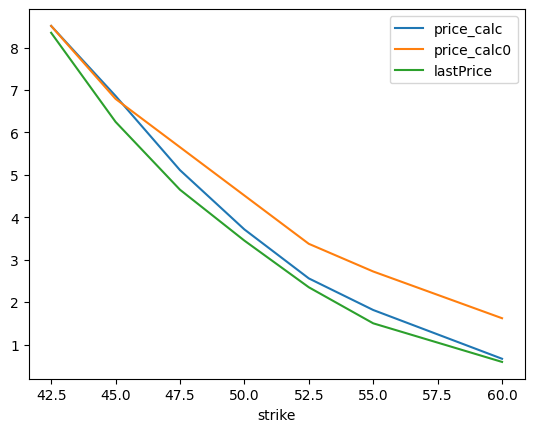

In [63]:
csco_opt_calls.iloc[1:, :].plot(kind='line', x='strike', y=['price_calc', 'price_calc0','lastPrice'])
